In [2]:
%load_ext blackcellmagic

In [3]:
from flask import Flask, request, render_template, jsonify, json
from decouple import config
from flask_cors import CORS
import numpy as np
import networkx as nx
import tweepy
import pandas as pd
import re
from collections import Counter
import asyncio
from concurrent.futures import ThreadPoolExecutor
import requests
import nest_asyncio
nest_asyncio.apply()

#set up twitter environment
TWITTER_AUTH =tweepy.OAuthHandler(config('TWITTER_CONSUMER_KEY'),config('TWITTER_CONSUMER_SECRET'))
#TWITTER_AUTH.set_access_token(config('TWITTER_ACCESS_TOKEN'),config('TWITTER_ACCESS_TOKEN_SECRET'))
TWITTER = tweepy.API(TWITTER_AUTH)

In [4]:
from flask import abort
from decouple import config
import tweepy
from collections import Counter
import asyncio
from concurrent.futures import ThreadPoolExecutor
import nest_asyncio

nest_asyncio.apply()


def process_request(request):
    """
    """
    from flask import abort

    content_type = request.headers["content-type"]
    request_json = request.get_json(silent=True)
    request_args = request.args

    if content_type == "application/json":
        request_json = request.get_json(silent=True)
        # TWITTER_ACCESS_TOKEN check/set/error
        if request_json and "TWITTER_ACCESS_TOKEN" in request_json:
            TWITTER_ACCESS_TOKEN = request_json["TWITTER_ACCESS_TOKEN"]
        else:
            raise ValueError("Missing a 'TWITTER_ACCESS_TOKEN'")
        # TWITTER_ACCESS_TOKEN_SECRET check/set/error
        if request_json and "TWITTER_ACCESS_TOKEN_SECRET" in request_json:
            TWITTER_ACCESS_TOKEN_SECRET = request_json["TWITTER_ACCESS_TOKEN_SECRET"]
        else:
            raise ValueError("Missing a 'TWITTER_ACCESS_TOKEN_SECRET'")

        if request_json and "search" in request_json:
            search = request_json["search"]
        else:
            raise ValueError("Missing a search term")

        # Call the function for the POST request.
        if request.method == "POST":
            establish_twitter_credentials(
                TWITTER_ACCESS_TOKEN, TWITTER_ACCESS_TOKEN_SECRET
            )
            return main(search)
    else:
        return abort(405)


def establish_twitter_credentials(TWITTER_ACCESS_TOKEN, TWITTER_ACCESS_TOKEN_SECRET):
    """establish Twitter as as global. No need to pass it everytime.
    """
    twitter_auth = tweepy.OAuthHandler(
        config("TWITTER_CONSUMER_KEY"), config("TWITTER_CONSUMER_SECRET")
    )
    access_token = TWITTER_ACCESS_TOKEN
    access_token_secret = TWITTER_ACCESS_TOKEN_SECRET
    twitter_auth.set_access_token(access_token, access_token_secret)
    global TWITTER
    TWITTER = tweepy.API(twitter_auth)


def main(search):
    """
    1. Establish the edge_list as an empty list
    2. Call the two executor functions, updating & passing the edge_list as it goes
    3. Return the edge_list
    """
    edge_list = []
    edge_list, top_interactions = execute_async_input_user_event_loop(search, edge_list)
    edge_list = execute_async_interactions_event_loop(top_interactions, edge_list)
    edge_list_dict = {"edge_list": edge_list}

    return json.dumps(edge_list)


def execute_async_input_user_event_loop(search, edge_list):
    """
    This function does something analogous to compiling the get_data_asynchronously function,
    Then it executes loop.
    1. Call the get_data_function
    2. Get the event_loop
    3. Run the tasks (Much easier to understand in python 3.7, "ensure_future" was changed to "create_task")
    4. Edge_list and top_interactions will be passed to the next functions
    """
    future = asyncio.ensure_future(get_input_user_data_asynchronous(search, edge_list))
    loop = asyncio.get_event_loop()
    loop.run_until_complete(future)
    return edge_list, top_interactions


async def get_input_user_data_asynchronous(search, edge_list):
    """
    1. Establish an executor and number of workers
    2. Establish the session
    3. Establish the event loop
    4. Create the tasks. Add two lists together. (because as I understand appending adds the list inside of a list.)
        4a. tasks are created by list comprenhensions
    5. Gather tasks.
    """
    with ThreadPoolExecutor(max_workers=20) as executor:
        with requests.Session() as session:
            loop = asyncio.get_event_loop()
            tasks = [
                loop.run_in_executor(
                    executor, get_user_timeline, *(session, search, edge_list, page)
                )
                for page in range(10)
            ] + [
                loop.run_in_executor(
                    executor, get_user_favorites, *(session, search, edge_list, page)
                )
                for page in range(10)
            ]
            for response in await asyncio.gather(*tasks):
                pass


def get_user_timeline(session, search, edge_list, page):
    """
    1. Get 200 user tweets
    2. Use a necessarily complex list comprehension to put each individual name mentioned in a tweet into a list
    3. make and return the edge_list: a list of tuples of the (search user, interaction)
    4. make and return the top_interactions: a list of top interactions using the python Counter function
    """
    timeline = TWITTER.user_timeline(
        id=search,
        count=200,
        exclude_replies=False,
        include_rts=True,
        tweet_mode="extended",
        page=page,
    )
    timeline = [
        user_mentions["screen_name"]
        for um_list in [tweet.entities["user_mentions"] for tweet in timeline]
        for user_mentions in um_list
    ]
    # timeline = [i for sublist in timeline for i in sublist]
    edge_list += [(search, i) for i in timeline]
    global top_interactions
    top_interactions = [i for i in Counter(timeline).most_common(10)]
    top_interactions = [i[0] for i in top_interactions]
    return top_interactions, edge_list


def get_user_favorites(session, search, edge_list, page):
    """
    1. Get 200 user favorites
    2. Extract the author from each favorited tweet.
    3. Make and return the edge_list: a list of tuples of the (search user, interaction)
    """
    timeline = TWITTER.favorites(
        id=search,
        count=200,
        exclude_replies=False,
        include_rts=True,
        tweet_mode="extended",
        page=page,
    )
    timeline = [tweet.author.screen_name for tweet in timeline]
    edge_list += [(i, search) for i in timeline]
    return edge_list


def execute_async_interactions_event_loop(top_interactions, edge_list):
    """
    This function does something analogous to compiling the get_data_asynchronously function,
    Then it executes loop.
    1. Call the get_data_function
    2. Get the event_loop
    3. Run the tasks (Much easier to understand in python 3.7, "ensure_future" was changed to "create_task")
    4. Edge_list and top_interactions will be passed to the next functions
    """
    future = asyncio.ensure_future(
        get_interactions_data_asynchronous(top_interactions, edge_list)
    )
    loop = asyncio.get_event_loop()
    loop.run_until_complete(future)
    return edge_list


async def get_interactions_data_asynchronous(top_interactions, edge_list):
    """
    1. Establish an executor and number of workers
    2. Establish the session
    3. Establish the event loop
    4. Create the tasks. Add two lists together. (because as I understand appending adds the list inside of a list.)
        4a. tasks are created by list comprenhensions
    5. Gather tasks.
    """
    with ThreadPoolExecutor(max_workers=20) as executor:
        with requests.Session() as session:
            loop = asyncio.get_event_loop()
            tasks = [
                loop.run_in_executor(
                    executor, get_user_timeline, *(session, search, edge_list, 1)
                )
                for search in top_interactions
            ] + [
                loop.run_in_executor(
                    executor, get_user_favorites, *(session, search, edge_list, 1)
                )
                for search in top_interactions
            ]
            for response in await asyncio.gather(*tasks):
                pass

In [5]:
%%time
edge_list= main("austen")

Wall time: 2.16 s


In [6]:
edge_list

'[["austen", "jojithumma"], ["austen", "paulg"], ["austen", "jojithumma"], ["austen", "paulg"], ["austen", "SooshiRollss"], ["austen", "LambdaSchool"], ["austen", "__Tux"], ["austen", "santiagosada"], ["austen", "paulg"], ["austen", "SooshiRollss"], ["austen", "LambdaSchool"], ["austen", "danouc"], ["austen", "paulg"], ["austen", "santiagosada"], ["austen", "paulg"], ["austen", "bjc290"], ["austen", "calcsam"], ["austen", "paulg"], ["austen", "AKGrenier"], ["austen", "indievc"], ["austen", "patio11"], ["austen", "paulg"], ["austen", "bjc290"], ["austen", "calcsam"], ["austen", "paulg"], ["austen", "AKGrenier"], ["austen", "indievc"], ["austen", "bjc290"], ["austen", "calcsam"], ["austen", "paulg"], ["austen", "AKGrenier"], ["austen", "juliankoh"], ["austen", "rabois"], ["austen", "TrentMano"], ["austen", "spoonwrite"], ["austen", "sethetter"], ["austen", "JasonToevs"], ["austen", "LambdaSchool"], ["austen", "BTrautschold"], ["austen", "jononomo"], ["austen", "hunterwalk"], ["austen", "

In [26]:
import pandas as pd

In [27]:
df = pd.DataFrame(edge_list)
pd.set_option("display.max_rows", len(df))

In [28]:
df

,0,1
0,austen,nullagent
1,austen,zackkanter
2,austen,gw_smiles
3,austen,soraschools
4,austen,jayvasdigital
5,austen,deus_vult23
6,austen,LambdaSchool
7,austen,_sharpobject
8,austen,Sp8cdRepetition
9,austen,robertnessler


In [29]:
len(df)

9632

In [30]:
#visualizing network

In [40]:
import networkx
import matplotlib.pyplot as plt

In [41]:
MG = nx.MultiGraph()

In [42]:
MG = nx.from_pandas_edgelist(df,0,1)

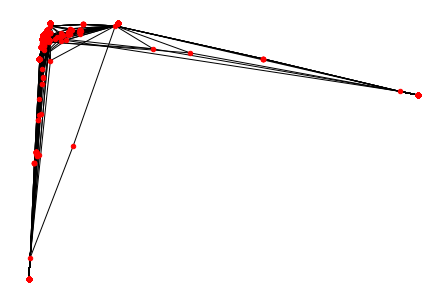

In [48]:
nx.draw_spectral(MG,  node_size=20, node_color='red')
plt.show;

KeyboardInterrupt: 

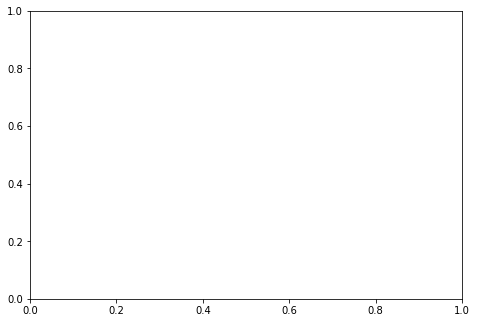

In [49]:
nx.draw(MG, node_size=20)
plt.show;